In [46]:
import csv
file_path = './benchmark_results.csv'
models_list = ["784_56_10", "196_25_10", "196_24_14_10", "28_6_16_10_5", "14_5_11_80_10_3"]

## Prepare

In [18]:
import csv
def read_data_for_architectures(file_path, target_architectures):
    # Ensure target_architectures is a list for uniform processing
    if isinstance(target_architectures, str):
        target_architectures = [target_architectures]

    results = {arch: {} for arch in target_architectures}

    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        
        for row in reader:
            framework = row['Framework']
            #frameworks.append(framework)
            architecture = row['Architecture']
            
            for target_arch in target_architectures:
                if architecture.lower() == target_arch.lower():
                    # This line ensures the last matching entry for each framework is kept
                    results[target_arch][framework] = [
                        row['Accuracy Loss (%)'],
                        row['Avg Memory Usage (MB)'],
                        row['Std Memory Usage'],
                        row['Avg Proving Time (s)'],
                        row['Std Proving Time']
                    ]
    
    return results


In [7]:
def target_arch(model_name):
    layers = model_name.split("_")
    if int(layers[0]) < 30:
        arch = "Input-Conv2d-Conv2d" + (len(layers)-4) * "-Dense" + "_Kernal"
        layers[0] = str(int(layers[0])**2)
        target = f'{arch} ({"x".join(layers[:-1])}_{layers[-1]}x{layers[-1]})'
    else:
        layers = model_name.split("_")
        arch = "Input" + (len(layers)-1) * "-Dense"
        target = f'{arch} ({"x".join(layers)})'
    
    return target

### Combine benchmark results

In [ ]:
import csv
import pandas as pd

def read_and_combine_data(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    #print ('Header:', df.head())

    # Group data by Framework and Architecture for processing
    grouped = df.groupby(['Framework', 'Architecture'])
    #print (grouped)
    
    for (framework, architecture), group in grouped:
        if len(group) == 2:  # Expecting two entries per group for combination
            base = group.iloc[0]
            follow_up = group.iloc[1]
            
            # Ensure we start with the base and follow up in the correct order
            if "start from 1000" in str(follow_up['Notes']):
                base, follow_up = follow_up, base  # Swap if in wrong order
            
            combined = base.copy()
            n1, n2 = 1000, 1500
            combined['Testing Size'] = 2500
            
            # Combine the metrics
            for metric in ['Accuracy Loss (%)', 'Avg Memory Usage (MB)', 'Avg Proving Time (s)']:
                combined[metric] = (n1 * base[metric] + n2 * follow_up[metric]) / (n1 + n2)
                
            for metric in ['Std Memory Usage', 'Std Proving Time']:
                # Placeholder for standard deviation combination, here we simply copy from follow_up
                # In reality, you should calculate combined standard deviation using a proper statistical method
                combined[metric] = follow_up[metric]
                

            combined['Notes'] = "Combined 0-2500"
            combined = combined.to_dict()
            for key in combined:
                combined[key] = [combined[key]]

            new_row_df = pd.DataFrame(combined)
            df = pd.concat([df, new_row_df], ignore_index=True)

    df.to_csv(file_path, index=False)

In [12]:
file_path = './cnn_accu.csv'  # Update this to your actual file path
read_and_combine_data(file_path)

In [13]:
file_path = './cnn_dnn.csv'  # Update this to your actual file path
read_and_combine_data(file_path)

In [19]:
file_path = './dnn_layer.csv'  # Update this to your actual file path
read_and_combine_data(file_path)

### Fix layers & Value accuarcy

In [23]:
archs = ['input-dense-dense (196x25x10)', 'input-dense-dense (784x56x10)']
data = read_data_for_architectures('./dnn_layer.csv', archs)

In [29]:
def extract(data, architectures):
    frameworks = list(data[archs[0]].keys())

    memory_usage = {arch: [] for arch in architectures}
    accuracy_loss = {arch: [] for arch in architectures}
    proving_time = {arch: [] for arch in architectures}

    # Iterate over the original data to populate the new structures
    for arch, fw_data in data.items():
        for fw in frameworks:
            # Append memory usage and proving time to the respective dictionaries
            # Convert string values to float for numerical processing
            accuracy_loss[arch].append(float(fw_data[fw][0]))
            memory_usage[arch].append(float(fw_data[fw][1]))
            proving_time[arch].append(float(fw_data[fw][3]))

    return frameworks, accuracy_loss, memory_usage, proving_time

In [32]:
frameworks, accuracy_loss, memory_usage, proving_time = extract(data, archs)


In [33]:
def normalize(data):
    """Normalize the data using min-max normalization."""
    min_val = min(data)
    max_val = max(data)
    return [(x - min_val) / (max_val - min_val) if max_val - min_val else 0 for x in data]


In [35]:
# Normalize the data
normalized_memory_usage = {arch: normalize(values) for arch, values in memory_usage.items()}
normalized_proving_time = {arch: normalize(values) for arch, values in proving_time.items()}
normalized_accuracy_loss = {arch: normalize(values) for arch, values in accuracy_loss.items()}

print (normalized_accuracy_loss)
print (normalized_memory_usage)
print (normalized_proving_time)
# Sum the normalized values for each framework
summed_scores = {}
for arch in archs:
    summed_scores[arch] = [sum(values) for values in zip(normalized_memory_usage[arch], normalized_proving_time[arch], normalized_accuracy_loss[arch])]

# Example of how to print the summed scores for each architecture
for arch, scores in summed_scores.items():
    print(f"{arch}: {scores}")

# If you want to sum across architectures for each framework
total_scores_per_framework = [sum(scores) for scores in zip(*summed_scores.values())]

# Display total scores for each framework
for fw, score in zip(frameworks, total_scores_per_framework):
    print(f"{fw}: {score}")

{'input-dense-dense (196x25x10)': [0.0, 1.0, 0.0], 'input-dense-dense (784x56x10)': [1.0, 0.0, 0.0]}
{'input-dense-dense (196x25x10)': [0.0, 0.8140043114397552, 1.0], 'input-dense-dense (784x56x10)': [0.0, 0.010695555723987468, 1.0]}
{'input-dense-dense (196x25x10)': [0.0, 1.0, 0.9256963006287043], 'input-dense-dense (784x56x10)': [0.0, 0.5415780941231818, 1.0]}
input-dense-dense (196x25x10): [0.0, 2.814004311439755, 1.9256963006287044]
input-dense-dense (784x56x10): [1.0, 0.5522736498471693, 2.0]
circomlib-ml (tensorflow): 1.0
zkml (tensorflow): 3.3662779612869245
ezkl (pytorch): 3.9256963006287044


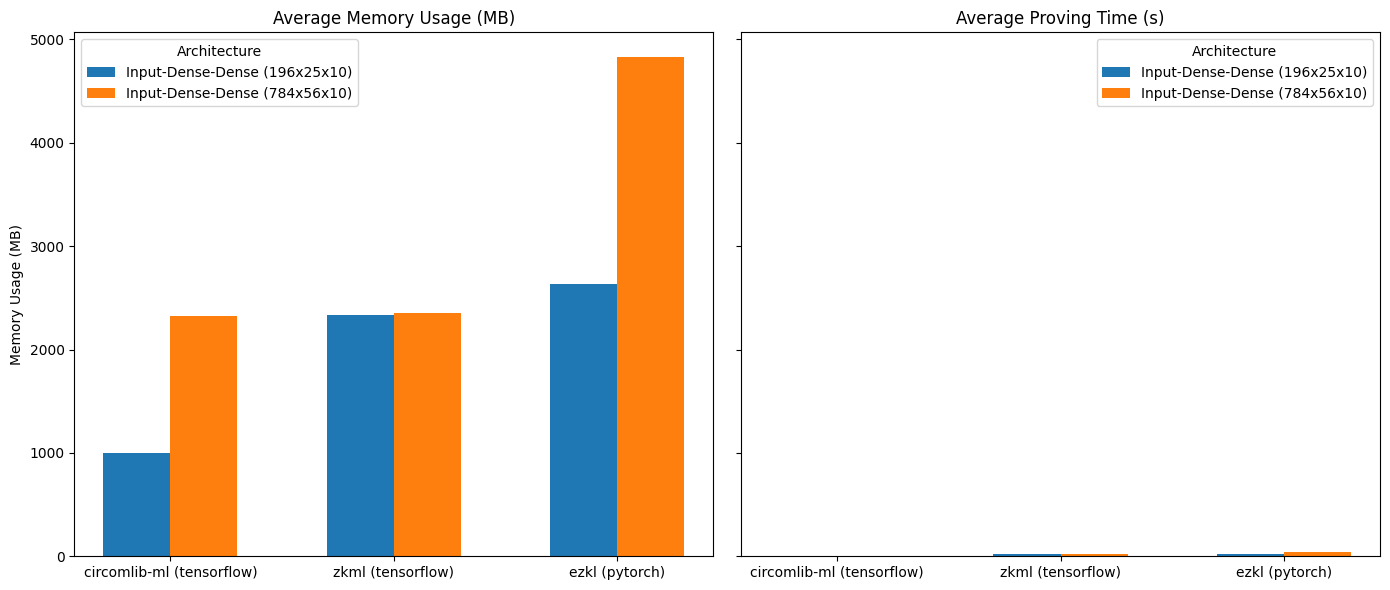

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted for plotting
frameworks = ['circomlib-ml (tensorflow)', 'zkml (tensorflow)', 'ezkl (pytorch)']
architectures = ['Input-Dense-Dense (196x25x10)', 'Input-Dense-Dense (784x56x10)']
memory_usage = {
    'Input-Dense-Dense (196x25x10)': [998.735128125, 2334.29562890625, 2636.28132421875],
    'Input-Dense-Dense (784x56x10)': [2328.3224109375, 2357.36315625, 4826.88769921875],
}
proving_time = {
    'Input-Dense-Dense (196x25x10)': [1.1694816182136536, 21.263429507017136, 19.52591128444672],
    'Input-Dense-Dense (784x56x10)': [2.351284250640869, 22.0125432472229, 38.13433733057976],
}

fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey='row')

# Plotting Memory Usage
for i, arch in enumerate(architectures):
    indices = np.arange(len(frameworks))
    ax[0].bar(indices + i*0.3, memory_usage[arch], width=0.3, label=arch)

ax[0].set_title('Average Memory Usage (MB)')
ax[0].set_xticks(indices + 0.3 / 2)
ax[0].set_xticklabels(frameworks)
ax[0].legend(title="Architecture")
ax[0].set_ylabel('Memory Usage (MB)')

# Plotting Proving Time
for i, arch in enumerate(architectures):
    indices = np.arange(len(frameworks))
    ax[1].bar(indices + i*0.3, proving_time[arch], width=0.3, label=arch)

ax[1].set_title('Average Proving Time (s)')
ax[1].set_xticks(indices + 0.3 / 2)
ax[1].set_xticklabels(frameworks)
ax[1].legend(title="Architecture")

plt.tight_layout()
plt.show()


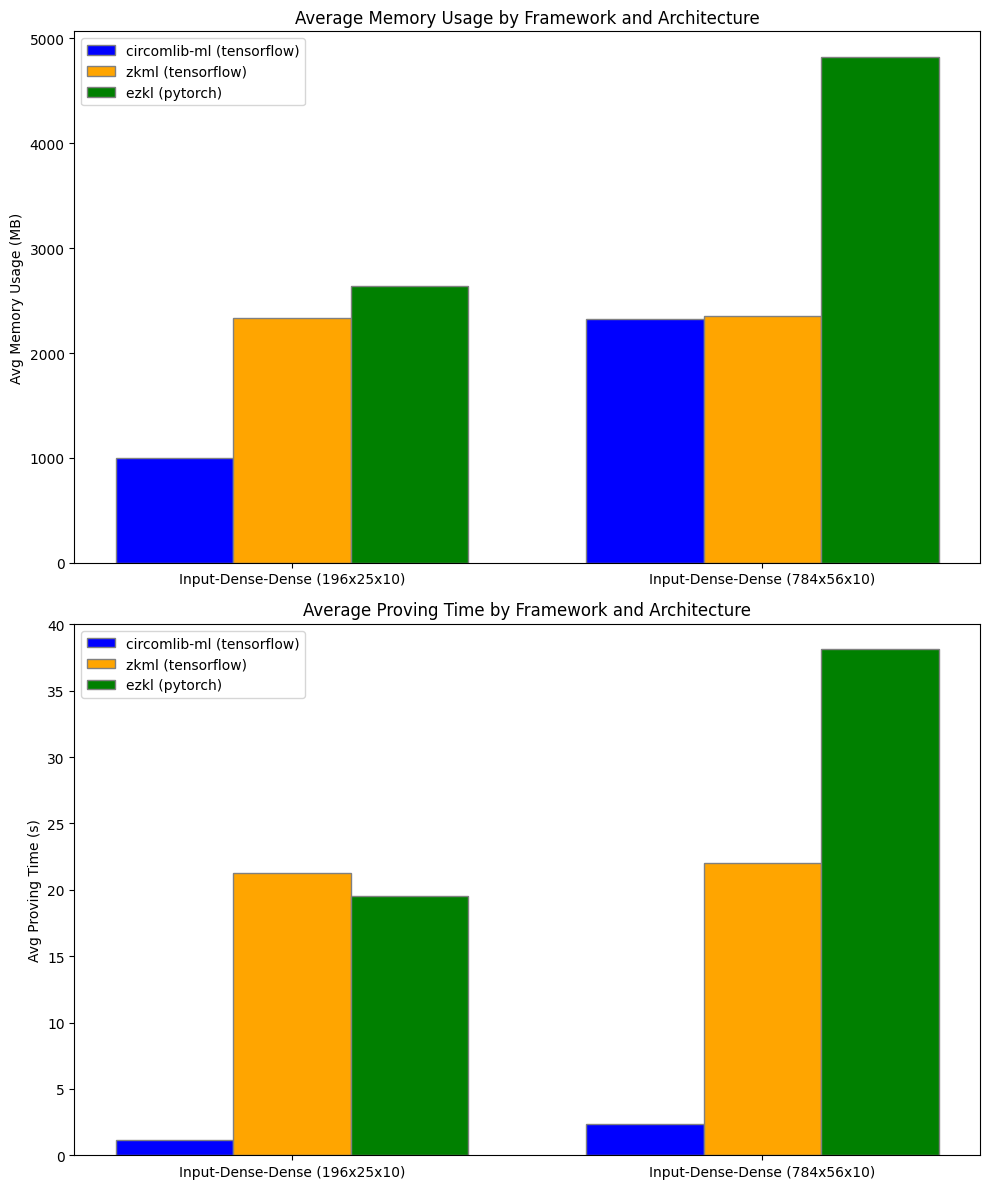

In [2]:
# Required libraries for plotting
import matplotlib.pyplot as plt
import numpy as np

# Data setup
frameworks = ['circomlib-ml (tensorflow)', 'zkml (tensorflow)', 'ezkl (pytorch)']
architectures = ['Input-Dense-Dense (196x25x10)', 'Input-Dense-Dense (784x56x10)']
colors = ['blue', 'orange', 'green']  # Color for each framework

# Memory Usage data (MB)
memory_usage_data = {
    'Input-Dense-Dense (196x25x10)': [998.735, 2334.296, 2636.281],  # [circomlib-ml, zkml, ezkl]
    'Input-Dense-Dense (784x56x10)': [2328.322, 2357.363, 4826.888],  # [circomlib-ml, zkml, ezkl]
}

# Proving Time data (s)
proving_time_data = {
    'Input-Dense-Dense (196x25x10)': [1.169, 21.263, 19.526],  # [circomlib-ml, zkml, ezkl]
    'Input-Dense-Dense (784x56x10)': [2.351, 22.013, 38.134],  # [circomlib-ml, zkml, ezkl]
}

fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Bar width
bar_width = 0.25
# Positions of the left bar-boundaries
r1 = np.arange(len(architectures))
# Positions of the bars for each framework
positions = [r1 + bar_width*i for i in range(len(frameworks))]

# Plot Memory Usage
for idx, fw in enumerate(frameworks):
    memory_usage = [memory_usage_data[arch][idx] for arch in architectures]
    axs[0].bar(positions[idx], memory_usage, color=colors[idx], width=bar_width, edgecolor='grey', label=fw)

axs[0].set_title('Average Memory Usage by Framework and Architecture')
axs[0].set_xticks([r + bar_width for r in range(len(architectures))])
axs[0].set_xticklabels(architectures)
axs[0].set_ylabel('Avg Memory Usage (MB)')
axs[0].legend()

# Plot Proving Time
for idx, fw in enumerate(frameworks):
    proving_time = [proving_time_data[arch][idx] for arch in architectures]
    axs[1].bar(positions[idx], proving_time, color=colors[idx], width=bar_width, edgecolor='grey', label=fw)

axs[1].set_title('Average Proving Time by Framework and Architecture')
axs[1].set_xticks([r + bar_width for r in range(len(architectures))])
axs[1].set_xticklabels(architectures)
axs[1].set_ylabel('Avg Proving Time (s)')
axs[1].legend()

plt.tight_layout()
plt.show()


### Change layers & Value lightweight

## CNN

### Best Overall

## Fix layers & Check perf diff